In [1]:
# Load Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Load Data file
data = pd.read_csv('day.csv')
data_org = data.copy()

In [3]:
# Numerical and Cateorical Variables
num_var = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
cat_var = ['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

In [4]:
'''# assigining categories/levels to categorical variable
for i in data.columns :
    if data[i].dtypes == 'object' :
        data[i] = pd.Categorical(data[i])
        data[i] = data[i].cat.codes
data.info()'''

"# assigining categories/levels to categorical variable\nfor i in data.columns :\n    if data[i].dtypes == 'object' :\n        data[i] = pd.Categorical(data[i])\n        data[i] = data[i].cat.codes\ndata.info()"

In [5]:
# Checking for Missing Values
for i in data.columns :
    print(i, data[i].isnull().sum())

instant 0
dteday 0
season 0
yr 0
mnth 0
holiday 0
weekday 0
workingday 0
weathersit 0
temp 0
atemp 0
hum 0
windspeed 0
casual 0
registered 0
cnt 0


,temp,atemp,hum,windspeed,casual,registered,cnt
temp,1,0.99,0.13,-0.16,0.54,0.54,0.63
atemp,0.99,1,0.14,-0.18,0.54,0.54,0.63
hum,0.13,0.14,1,-0.25,-0.077,-0.091,-0.1
windspeed,-0.16,-0.18,-0.25,1,-0.17,-0.22,-0.23
casual,0.54,0.54,-0.077,-0.17,1,0.4,0.67
registered,0.54,0.54,-0.091,-0.22,0.4,1,0.95
cnt,0.63,0.63,-0.1,-0.23,0.67,0.95,1


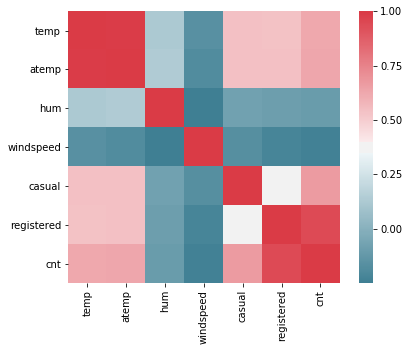

In [6]:
#Corelation Analysis
data_corr = data.loc[:,num_var]
f,ax = plt.subplots(figsize = (7,5))
corr = data_corr.corr()

import seaborn as sns
sns.heatmap(corr,mask = np.zeros_like(corr, dtype = np.bool),cmap = sns.diverging_palette(220,10,as_cmap=True),
            square = True, ax =ax)
cmap = sns.diverging_palette(5, 250, as_cmap=True)
#cmap = plt.cm.RdBu

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

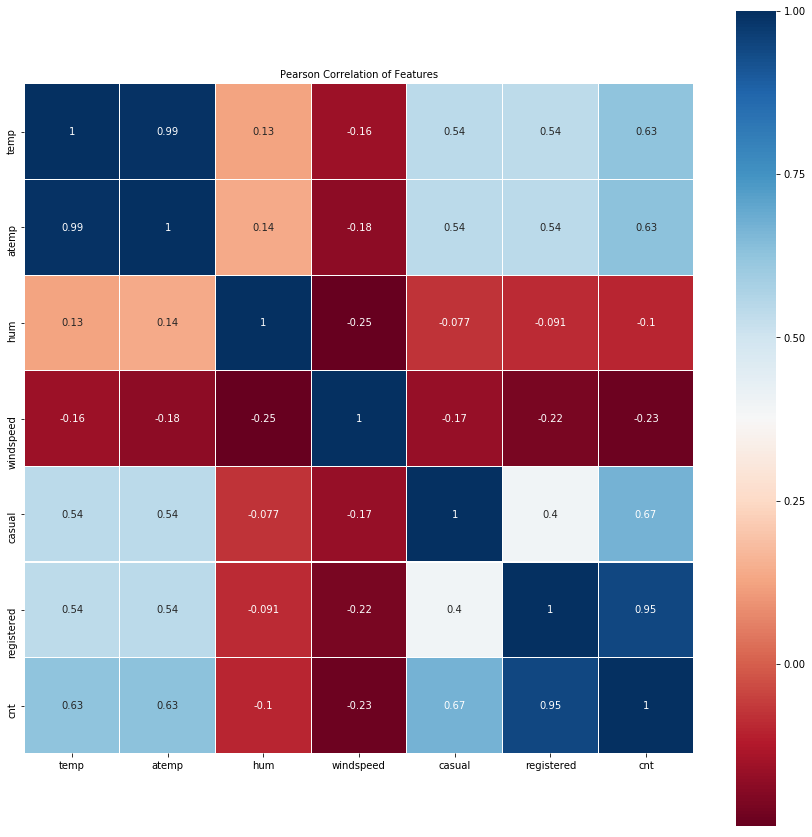

In [7]:
#correlation plot
colormap = plt.cm.RdBu
plt.figure(figsize=(15,15))
plt.title('Pearson Correlation of Features', y=1.0, size=10)
sns.heatmap(data_corr.corr(),linewidths=0.2,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [8]:
# Drop 'atemp' as highly corelated
data = data.drop(['atemp'],axis=1)
data = data.drop(['dteday'],axis=1) # not required

In [9]:
# Outlier Analysis, Capping and Flooring
for i in ['hum','windspeed','casual'] :
    q99, q01 = np.percentile(data[i],[99,1])
    data.loc[data[i] > q99,i] = q99 
    data.loc[data[i] < q01,i] = q01
# as casual variable is altered, so we have to update total count variables as 
# it is sum of casual and registered users
data['cnt'] = data['casual']+data['registered']

In [10]:
# Changing data type of categorical variable to object from integer
cat_var = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
for i in cat_var :
    data[i] = data[i].astype('category')
#data.info()

In [11]:
# check category  variables which do not require hot encoding
cat_var = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit']
for i in cat_var :
    print(i, data[i].unique())

season [1, 2, 3, 4]
Categories (4, int64): [1, 2, 3, 4]
yr [0, 1]
Categories (2, int64): [0, 1]
mnth [1, 2, 3, 4, 5, ..., 8, 9, 10, 11, 12]
Length: 12
Categories (12, int64): [1, 2, 3, 4, ..., 9, 10, 11, 12]
holiday [0, 1]
Categories (2, int64): [0, 1]
weekday [6, 0, 1, 2, 3, 4, 5]
Categories (7, int64): [6, 0, 1, 2, 3, 4, 5]
workingday [0, 1]
Categories (2, int64): [0, 1]
weathersit [2, 1, 3]
Categories (3, int64): [2, 1, 3]


In [12]:
num_var = ['temp','hum', 'windspeed','casual','registered']
df1 = data.applymap(int)
for i in cat_var:
    df1[i].astype('str')
temp = pd.DataFrame(df1['cnt'])
temp = temp.join(data[num_var])
for i in cat_var:
    d = pd.get_dummies(df1[i],prefix = i)
    temp = temp.join(d)
data_hotencod = temp
data_hotencod.shape,data_hotencod.columns

((731, 38),
 Index(['cnt', 'temp', 'hum', 'windspeed', 'casual', 'registered', 'season_1',
        'season_2', 'season_3', 'season_4', 'yr_0', 'yr_1', 'mnth_1', 'mnth_2',
        'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
        'mnth_10', 'mnth_11', 'mnth_12', 'holiday_0', 'holiday_1', 'weekday_0',
        'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
        'weekday_6', 'workingday_0', 'workingday_1', 'weathersit_1',
        'weathersit_2', 'weathersit_3'],
       dtype='object'))

In [13]:
new_data = data_hotencod.drop(['cnt','registered','casual'],axis=1)
cas_data = pd.DataFrame(data_hotencod['casual']).join(new_data)
reg_data = pd.DataFrame(data_hotencod['registered']).join(new_data)

In [14]:
#selecting topfeatures for 'casual'
from sklearn.feature_selection import SelectKBest, f_regression
cas_new = SelectKBest(f_regression,k=30).fit_transform(cas_data.iloc[:,1:],cas_data.iloc[:,0])

##selecting top features for 'registered'
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
reg_new = SelectKBest(f_regression,k=30).fit_transform(reg_data.iloc[:,1:],reg_data.iloc[:,0])

In [15]:
# Selecting train and test sample
# observations for 'casual' and 'registered' should be in same order, so to compare thr
# summation to 'cnt' of data

# train : test, ratio(80:20)

## 'casual' customers
X_train_cas=cas_new[:485:1]
X_test_cas=cas_new[486::1]
y_train_cas=cas_data.iloc[:485,0]
y_test_cas=cas_data.iloc[486:,0]


## 'registered' customers

X_train_reg=reg_new[:485:1]
X_test_reg=reg_new[486::1]
y_train_reg=reg_data.iloc[:485,0]
y_test_reg=reg_data.iloc[486:,0]

y_test_count=data_hotencod.iloc[486:,0]

In [16]:
# Defining Model to predict and calculate error metrics
def model_pred(model) :
    cas_model = model.fit(X_train_cas,y_train_cas)
    cas_pred = model.predict(X_test_cas)
    print('Casual :')
    print('RMSE : ',np.sqrt(mean_squared_error(y_test_cas,cas_pred)))
    print('Model Score :', model.score(X_test_cas, y_test_cas))
    
    reg_model = model.fit(X_train_reg,y_train_reg)
    reg_pred = model.predict(X_test_reg)
    print('Registered :')
    print('RMSE : ',np.sqrt(mean_squared_error(y_test_reg,reg_pred)))
    print('Model Score :', model.score(X_test_reg, y_test_reg))
    
    cnt_pred = cas_pred + reg_pred
    
    print('Count :')
    print('RMSE : ',np.sqrt(mean_squared_error(y_test_count,cnt_pred)))
    return

In [17]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
model = DecisionTreeRegressor()
model_pred(model)

Casual :
RMSE :  903.6861970703715
Model Score : -0.5651589376065702
Registered :
RMSE :  1089.1115551640414
Model Score : 0.3561179589239176
Count :
RMSE :  1385.7789345155088


In [18]:
#Random forest
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model_pred(model)

Casual :
RMSE :  413.84647783338943
Model Score : 0.6717523130559503
Registered :
RMSE :  1042.684738762863
Model Score : 0.40984292963373886
Count :
RMSE :  1120.7926148274876


In [19]:
#Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model_pred(model)

Casual :
RMSE :  424.9209000388145
Model Score : 0.6539496178882476
Registered :
RMSE :  903.1730955328001
Model Score : 0.5572041270279229
Count :
RMSE :  1051.715014306732


In [20]:
#Ridge Regression
from sklearn.linear_model import Ridge
model=Ridge()
model_pred(model)

Casual :
RMSE :  418.29190291508917
Model Score : 0.6646625455000048
Registered :
RMSE :  910.5746161979094
Model Score : 0.5499169484223905
Count :
RMSE :  1058.751163972777


In [21]:
#Lasso regression
from sklearn.linear_model import Lasso
model=Lasso()
model_pred(model)

Casual :
RMSE :  418.3696542090059
Model Score : 0.6645378701524947
Registered :
RMSE :  901.2962307577742
Model Score : 0.5590425442001858
Count :
RMSE :  1049.5571529310841


In [22]:
#Lars Regression
from sklearn.linear_model import Lars
model=Lars()
model_pred(model)

Casual :
RMSE :  438.0828673911513
Model Score : 0.632179707138155
Registered :
RMSE :  988.5553438873961
Model Score : 0.4695266669733078
Count :
RMSE :  1153.1921703661671


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.395e+00, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.572e+00, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.572e+00, with an active set of 13 regressors, and the smallest cholesky pivot element

In [23]:
cas_data.shape

(731, 36)

Text(0.5,1,'For Registered')

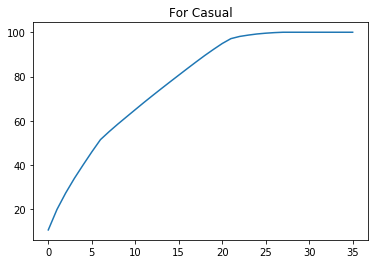

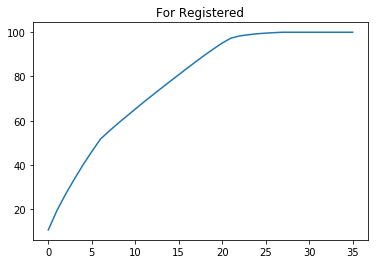

In [24]:
# PCA feature engineering/dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
y_test_count=data_hotencod.iloc[485:,0]

pca_cas = PCA(n_components=36)
pca_reg=PCA(n_components=36)

pca_cas.fit(scale(cas_data.values))
pca_reg.fit(scale(reg_data.values))

#The amount of variance that each PC explained
var_cas= pca_cas.explained_variance_ratio_
var_reg= pca_reg.explained_variance_ratio_

#Cumulative Variance 
var1_cas=np.cumsum(np.round(pca_cas.explained_variance_ratio_, decimals=4)*100)
var1_reg=np.cumsum(np.round(pca_reg.explained_variance_ratio_, decimals=4)*100)


#graph of the variance
    

plt.plot(var1_cas)
plt.title('For Casual')
plt.figure()
plt.plot(var1_reg)
plt.title('For Registered')

In [25]:
# 25 componentsaround ~100% variance in the data set.

 
#Looking at above 25 variables to be opted
pca_cas = PCA(n_components=25)
pca_reg = PCA(n_components=25)


#now fitting the selected components to the data
pca_cas.fit(cas_data.values)
pca_cas.fit(reg_data.values)


#PCA selected features
X_cas=pca_cas.fit_transform(cas_data.values)
X_reg=pca_reg.fit_transform(reg_data.values)

#splitting train and test data

X_train_cas=X_cas[:485:1]
X_test_cas=X_cas[486::1]
y_train_cas=cas_data.iloc[:485,0]
y_test_cas=cas_data.iloc[486:,0]

X_train_reg=X_reg[:485:1]
X_test_reg=X_reg[486::1]
y_train_reg=reg_data.iloc[:485,0]
y_test_reg=reg_data.iloc[486:,0]

y_test_count=data_hotencod.iloc[486:,0]

In [26]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
model = DecisionTreeRegressor()
model_pred(model)

Casual :
RMSE :  42.5152851265022
Model Score : 0.9965357171829309
Registered :
RMSE :  289.28379540809794
Model Score : 0.9545734458969894
Count :
RMSE :  289.1646090067746


In [27]:
#Random forest
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model_pred(model)

Casual :
RMSE :  35.67581348413966
Model Score : 0.9975606679766904
Registered :
RMSE :  339.8425087223402
Model Score : 0.9373072987792951
Count :
RMSE :  342.11128959412474


In [28]:
#Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model_pred(model)

Casual :
RMSE :  3.547339111275124e-06
Model Score : 1.0
Registered :
RMSE :  3.782118120433597e-06
Model Score : 1.0
Count :
RMSE :  0.11814831217788235


In [29]:
#Ridge Regression
from sklearn.linear_model import Ridge
model=Ridge()
model_pred(model)

Casual :
RMSE :  8.930311115663387e-06
Model Score : 0.9999999999999999
Registered :
RMSE :  9.066035869074959e-06
Model Score : 1.0
Count :
RMSE :  0.11814817778624645


In [30]:
#Lasso regression
from sklearn.linear_model import Lasso
model=Lasso()
model_pred(model)

Casual :
RMSE :  0.0024515655065256528
Model Score : 0.9999999999884811
Registered :
RMSE :  0.001788723282169211
Model Score : 0.9999999999982632
Count :
RMSE :  0.11768478358674006


In [31]:
#Lars Regression
from sklearn.linear_model import Lars
model=Lars()
model_pred(model)

Casual :
RMSE :  1.3444259826313079e-05
Model Score : 0.9999999999999997
Registered :
RMSE :  1.8683109041878958e-05
Model Score : 0.9999999999999998
Count :
RMSE :  0.11815049878536144


In [32]:
scale()?

SyntaxError: invalid syntax (<ipython-input-32-0bd232f64fd4>, line 1)

In [40]:
scale(reg_data.values)[]

AttributeError: 'numpy.ndarray' object has no attribute 'info'